# Ultimate Inc. DS Challenge

## Part 1 - Exploratory Data Analysis

In [236]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [27]:
# read in data
with open('logins.json', 'r') as f:
    logins_json = json.load(f)

In [237]:
# get json keys
logins_json.keys()

dict_keys(['login_time'])

In [238]:
# get list of login times
logins = logins_json['login_time']

In [239]:
# check length
len(logins)

93142

In [240]:
# check format
logins[0]

'1970-01-01 20:13:18'

In [241]:
len(logins[0])

19

In [33]:
# check that all login times are the same length of string in case there are errors in the dataset
for idx, login in enumerate(logins):
    assert len(login) == 19

In [34]:
# put login times into df along with count 1 for each login
# login times are datetime objects
df_logins = pd.DataFrame({'login_time':pd.to_datetime(logins), 'login_count':1})
df_logins.head()

,login_time,login_count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [35]:
# sort by login time and 
df_logins = df_logins.sort_values(by='login_time').set_index('login_time')

In [37]:
# resample every 15 minutes and count logins for each 15 min period
df_15 = df_logins.resample('15T').sum()
df_15.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Logins every 15 minute period

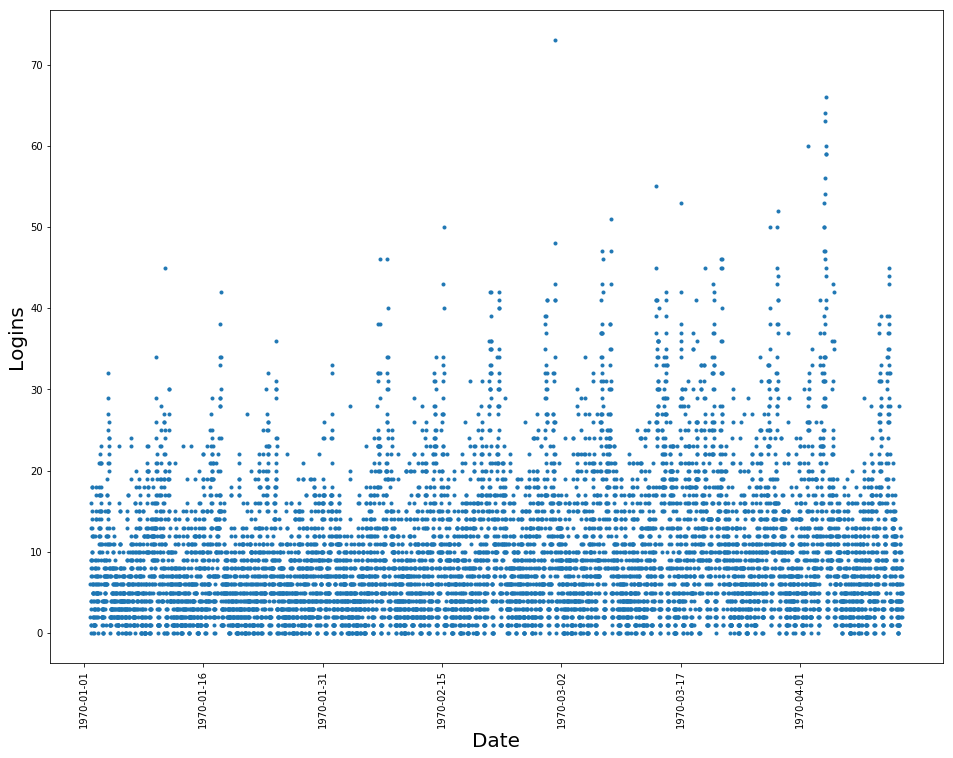

In [134]:
xticks = list(df_logins.resample('15D').sum().index.strftime('%Y-%m-%d'))

fig, ax = plt.subplots(figsize=(16,12))
plt.plot(df_15['login_count'], '.')
ax.set_xlabel('Date', fontsize=20)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.xticks(rotation=90)
ax.set_xticks(xticks)
ax.set_ylabel('Logins', fontsize=20)
plt.show()

- From the beginning to end of the dataset there is a general increase in logins
- Logins spike weekly on weekends

### Total logins by 15 minute period daily

In [67]:
# plot logins by 15 minute periods for all days combined
df_15_day = df_15.groupby([df_15.index.hour, df_15.index.minute]).login_count.sum()

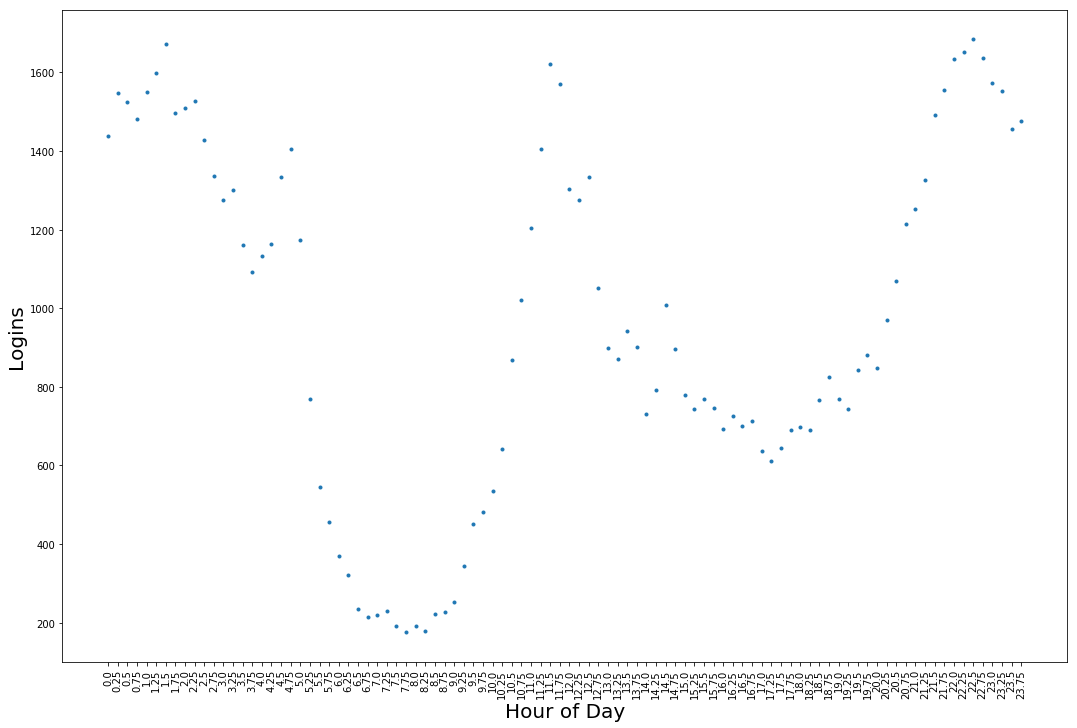

In [133]:
import math
hours = [df_15_day.index.levels[0][math.floor(i / 4)] for i in range(96)]
minutes = list(df_15_day.index.levels[1] / 60) * 24
xticks = [sum(x) for x in zip(hours, minutes)]

fig, ax = plt.subplots(figsize=(18,12))
plt.plot(df_15_day.values, '.')
ax.set_xlabel('Hour of Day', fontsize=20)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.xticks(rotation=90)
ax.set_xticks(range(len(xticks)))
ax.set_xticklabels(xticks)
ax.set_ylabel('Logins', fontsize=20)
plt.show()

- Logins peak just before and after midnight, and just before noon.
- Logins at the lowest level between 6-8am. 

### Total logins by day of week

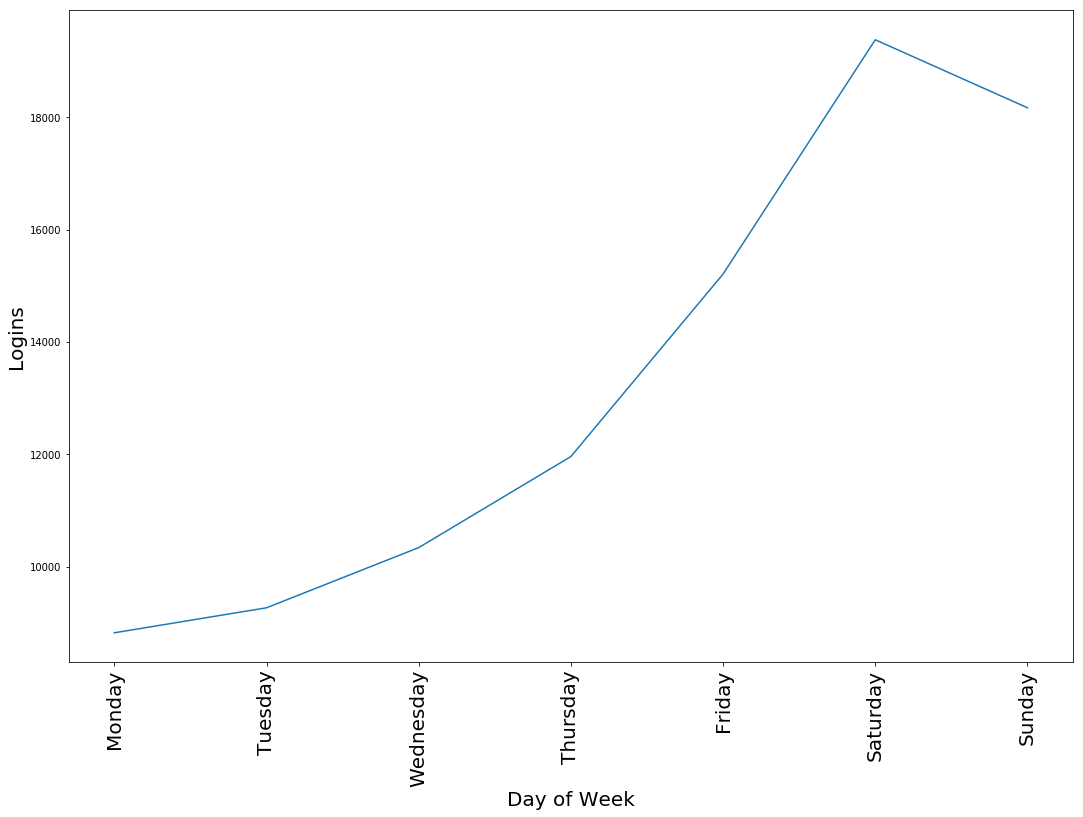

In [131]:
# plot logins by day of the week
df_15_day_day = df_15.groupby([df_15.index.dayofweek]).login_count.sum()
xticks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(18,12))
plt.plot(df_15_day_day.values)
ax.set_xlabel('Day of Week', fontsize=20)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.xticks(rotation=90)
ax.set_xticks(range(len(xticks)))
ax.set_xticklabels(xticks, fontsize=20)
ax.set_ylabel('Logins', fontsize=20)
plt.show()

- Overall, total rides increases from Monday-Saturday.
- Sunday slightly lower than saturday.

### Total logins every 15 minute period weekly

In [137]:
df_15_min_week = df_15.groupby([df_15.index.dayofweek, df_15.index.hour, df_15.index.minute]).login_count.sum()

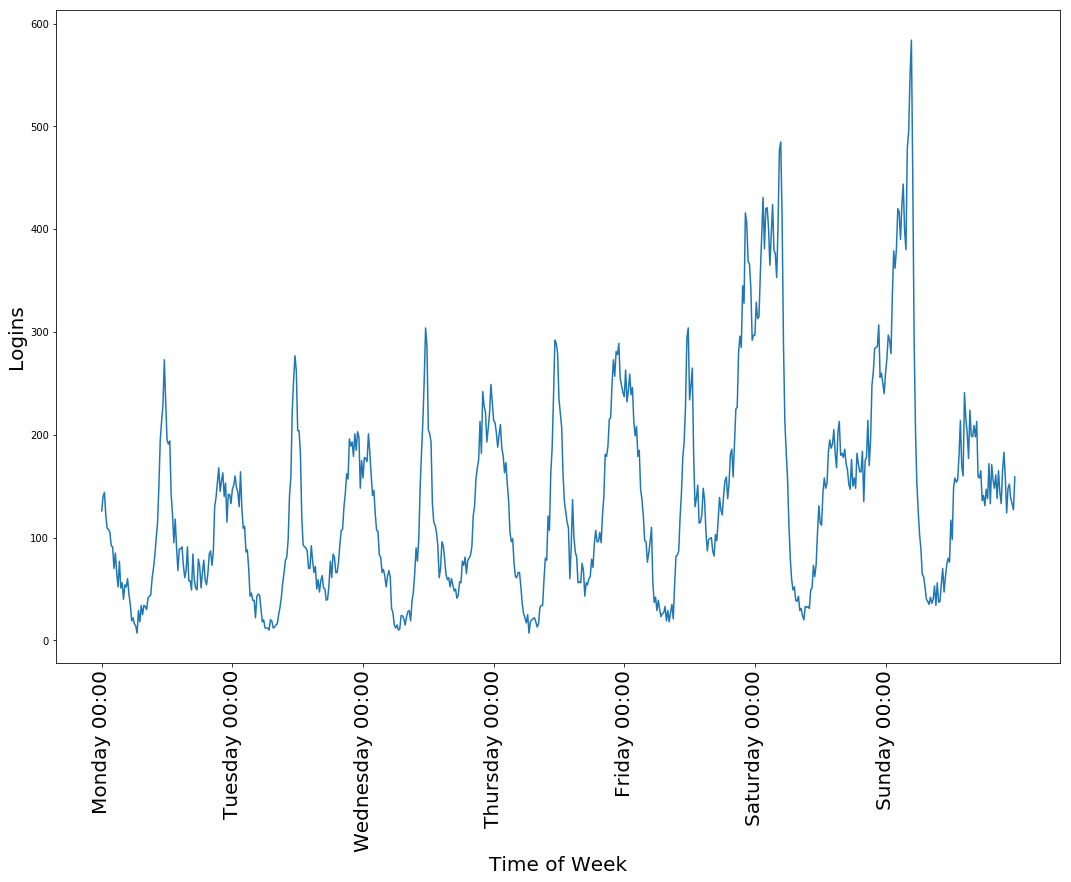

In [152]:
xticks = ['Monday 00:00', 'Tuesday 00:00', 'Wednesday 00:00', 'Thursday 00:00', 'Friday 00:00', 'Saturday 00:00', 'Sunday 00:00']

fig, ax = plt.subplots(figsize=(18,12))
plt.plot(df_15_min_week.values)
ax.set_xlabel('Time of Week', fontsize=20)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.xticks(rotation=90)
ax.set_xticks(np.arange(0, len(df_15_min_week.values), 96))
ax.set_xticklabels(xticks, fontsize=20)
ax.set_ylabel('Logins', fontsize=20)
plt.show()

- A cyclical trend is seen throughout the week.
- Logins have similarly shaped peaks daily but overall logins increases as the week goes on. 

## Part 2 - Experiment and Metrics Design

### Problem:
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

An appropriate metric for determining success is for each driver to calculate the % of trips in the city where they do the majority of their trips, separate for weekdays and weekends. Therefore, a 'perfect' non-exclusive score would be 50%. A completely exclusive driver would have a score of 100%. The mean of the drivers scores can be calculated to determine the baseline mean % of majority city trips. 

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment.

    b. what statistical test(s) you will conduct to verify the significance of the observation.

    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.


We can implement an A/B test. Give half the drivers the toll reimbursement incentive for one month - these drivers are Version B, the 'challenger'. The remaining half of the drivers do not receive toll reimbursement - these drivers are Version A, the 'control'.

The experiment is run, and we can now compare the two populations of drivers - Version A and Version B for weekdays and weekends. Statistical analysis would be performed as follows:
   - Calculate the % of each drivers trips that occur in each city. 
   - Take the highest % of trips from the two cities for each driver.
   - Two populations:
       - % of majority city trips for each Version A driver
       - % of majority city trips for each Version B driver
   - Resample with replacement n times (n=size of distribution) from each population 10,000 times to create 10,000 sets of bootstrapped samples. The mean of each of these samples are calculated as the replicate means.
   - The differences between each Version A and Version B replicate means are calculated.
   - Null Hypothesis: Drivers without the incentive have the same mean majority city % as drivers with the incentive.
   - Alternative Hypothesis: Drivers with the incentive have a lower mean majority city than drivers without the incentive.
   - The percentage of replicate mean differences being > desired change (or, > 0) is the chance that the difference between the two population means happened by chance. This percentage is compared to the level of certainty desired.
   
If the level of certainty is greater than the percentage of replicate mean differences >  desired change (or, > 0), we reject the null hypothesis, and conclude that there is a strong statistical likelihood that the toll reimbursement inventive has decreased the mean % of trips in majority cities. 

Assumptions:
- A trip is considered to be a part of a certain city if the start of the trip originates in that city.
- This experiment does not take into account trips that start in one city and end in another. 

## Part 3 - Predictive Modelling

The approach to predictive modelling is as follows:
- Drop all obvservations with NaN values - approx. 20% of dataset but we still have many observations remaining.
- Convert city and phone columns to categorical columns with a 1 indicating if a person belongs to each category.
- Set 'signup_date' feature to be an integer calculated as the number of seconds since the first user signed up.
- Split data into 70% train and 30% test datasets.
- Fit and predict using a random forest model. This model was chosen as it is simple to implement and can give a good initial idea of the ability of the target variable to be predicted. 
- Evaluate model using precision, recall, and F1 score. 

In [219]:
# get data
with open('ultimate_data_challenge.json', 'r') as f:
    data_json = json.load(f)

In [220]:
# input to dataframe
df = pd.DataFrame(data_json)

In [221]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [222]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [223]:
# Drop observations with no rating for driver or for passenger (20% of data - debatably too large of portion to cut)
df = df.dropna(axis=0)

In [224]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,5.460046,4.776446,4.601720,1.073822,8.898709,2.609675,61.254897
std,5.145174,0.404606,0.616104,0.198747,18.322061,4.059336,34.813848
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,37.500000
50%,3.780000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.490000,5.000000,5.000000,1.070000,11.100000,3.000000,100.000000
max,79.690000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [225]:
# Convert 'city' column to be different columns for each city category
city_columns = pd.get_dummies(df['city'], prefix='city')
df = pd.concat([df, city_columns], axis=1)
df = df.drop('city', axis=1)

# Convert 'ciphonety' column to be different columns for each phone category
phone_columns = pd.get_dummies(df['phone'], prefix='phone')
df = pd.concat([df, phone_columns], axis=1)
df = df.drop('phone', axis=1)

# Convert from true/false to 1/0 (not sure if necessary)
df['ultimate_black_user'] = [1 if x[1] == True else 0 for x in df['ultimate_black_user'].iteritems()]

# Convert signup_date column to be an integer of seconds since the first user signed up
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['signup_date'] = (df['signup_date'] - min(df['signup_date'])).dt.total_seconds()

In [226]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,2073600.0,15.4,4,1,46.2,0,1,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2419200.0,0.0,0,0,50.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,432000.0,0.0,3,0,100.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,777600.0,20.0,9,1,80.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2246400.0,11.8,14,0,82.4,0,0,1,1,0


In [242]:
df['last_trip_date'][0]

'2014-06-17'

In [243]:
# make retained columm
# Rider is retained if they have ridden in the last month
df['retained'] = np.where(df['last_trip_date'] >= '2014-05-17', 1, 0)

In [244]:
df['retained'].value_counts()

0    20748
1    20697
Name: retained, dtype: int64

In [245]:
# import sklearn functions
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [246]:
# set features and target variables
X = df.drop(['retained', 'last_trip_date'], axis=1)
y = df['retained']

In [247]:
# split data into X and y
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [248]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=1000,
                              random_state=42)

# fit and predict
forest.fit(X_train, y_train)
predictions = forest.predict(X_test)

# calculate and print scores
print('F1 Score: ', f1_score(y_test, predictions))
print('Precision Score: ', precision_score(y_test, predictions))
print('Recall Score: ', recall_score(y_test, predictions))

F1 Score:  0.7423857868020305
Precision Score:  0.730793254216115
Recall Score:  0.7543520309477756


In [253]:
# Compare scores if all 1s are guessed
print('F1 Score all ones: ', f1_score(y_test, np.ones(len(y_test))))
print('Precision Score all ones: ', precision_score(y_test, np.ones(len(y_test))))
print('Recall Score all ones: ', recall_score(y_test, np.ones(len(y_test))))

F1 Score all ones:  0.6657366670243589
Precision Score all ones:  0.49895447965256556
Recall Score all ones:  1.0


Feature ranking:
1. feature 0 (0.189186)
2. feature 8 (0.156066)
3. feature 4 (0.134923)
4. feature 6 (0.107928)
5. feature 1 (0.100586)
6. feature 2 (0.082938)
7. feature 5 (0.067679)
8. feature 3 (0.052419)
9. feature 10 (0.031972)
10. feature 7 (0.027787)
11. feature 12 (0.016128)
12. feature 13 (0.014829)
13. feature 9 (0.010577)
14. feature 11 (0.006982)


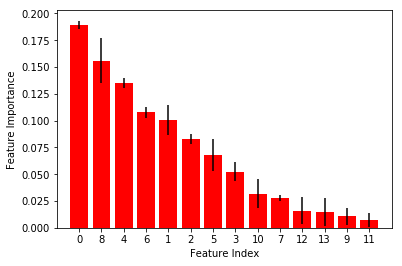

In [249]:
# get and plot feature importances

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()

In [235]:
for idx, column in enumerate(X.columns):
    print('Feature', idx, ': ', column)

Feature 0 :  avg_dist
Feature 1 :  avg_rating_by_driver
Feature 2 :  avg_rating_of_driver
Feature 3 :  avg_surge
Feature 4 :  signup_date
Feature 5 :  surge_pct
Feature 6 :  trips_in_first_30_days
Feature 7 :  ultimate_black_user
Feature 8 :  weekday_pct
Feature 9 :  city_Astapor
Feature 10 :  city_King's Landing
Feature 11 :  city_Winterfell
Feature 12 :  phone_Android
Feature 13 :  phone_iPhone


### Conclusions:

Key metrics:
- F1 Score:  0.74
- Precision Score:  0.73
- Recall Score:  0.75


- F1 Score all ones:  0.67
- Precision Score all ones:  0.50
- Recall Score all ones:  1.00

Most important features for prediction:

1) avg_dist

2) weekday_pct

3) signup_date

The model has predictive power. It achieves a precision and recall of 0.73 and 0.75, respectively. This information can be leveraged for example by incentivizing the users that are predicted as not being retained with a discount for a set number of rides to encourage use of the app. 
